In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import statsmodels.formula.api as smf 
from pandas.plotting import lag_plot
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product

In [2]:
# Loading Dataset
data = pd.read_excel(r'C:\Users\Sooraj\Downloads\Airlines+Data.xlsx')

In [3]:
data.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [4]:
data.shape

(96, 2)

In [5]:
data.isna().sum()

Month         0
Passengers    0
dtype: int64

In [6]:
data['Month'] = pd.to_datetime(data['Month'])

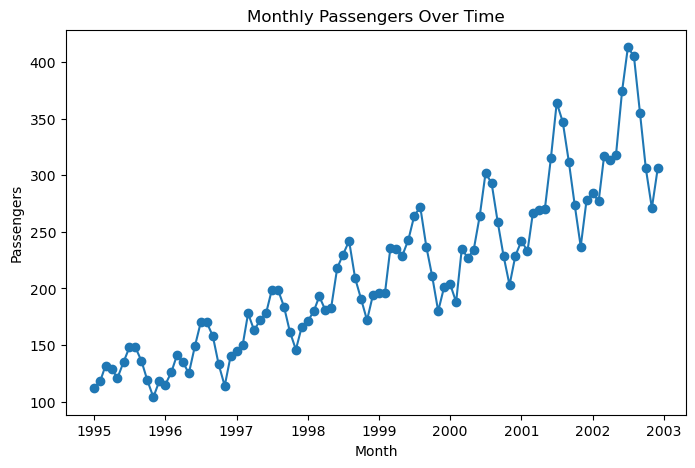

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(data['Month'], data['Passengers'], marker='o', linestyle='-')
plt.title('Monthly Passengers Over Time')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.show()

<Axes: >

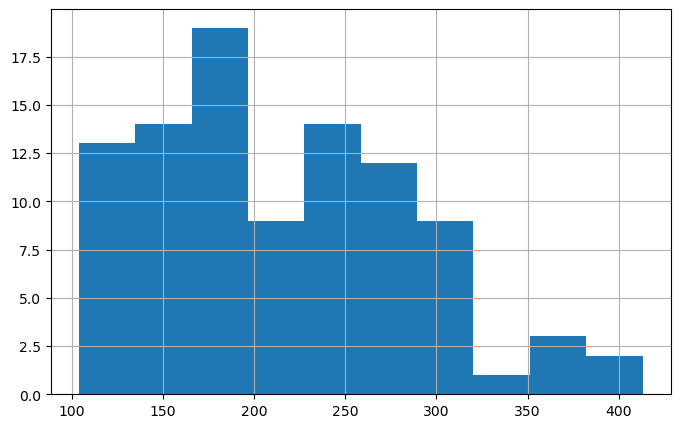

In [8]:
# Histogram
data['Passengers'].hist(figsize=(8,5))

<Axes: ylabel='Density'>

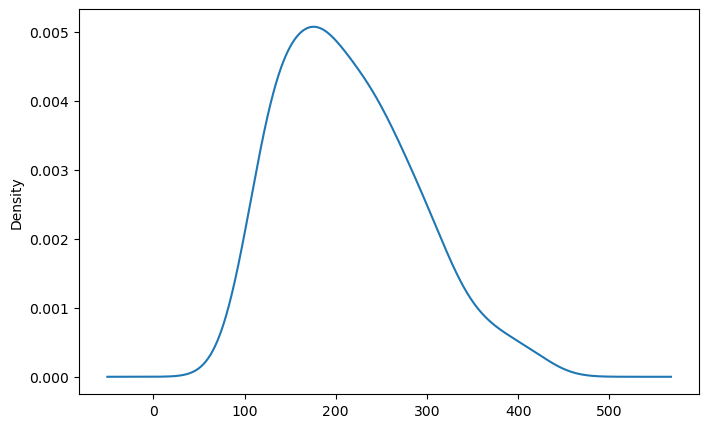

In [9]:
# Density Plot
data['Passengers'].plot(kind = 'kde', figsize=(8,5))

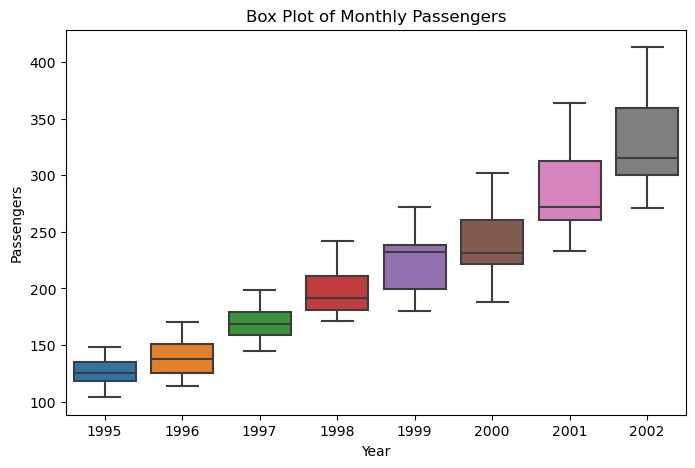

In [10]:
# Box plot
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['Month'].dt.year, y=data['Passengers'])
plt.title('Box Plot of Monthly Passengers')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.show()


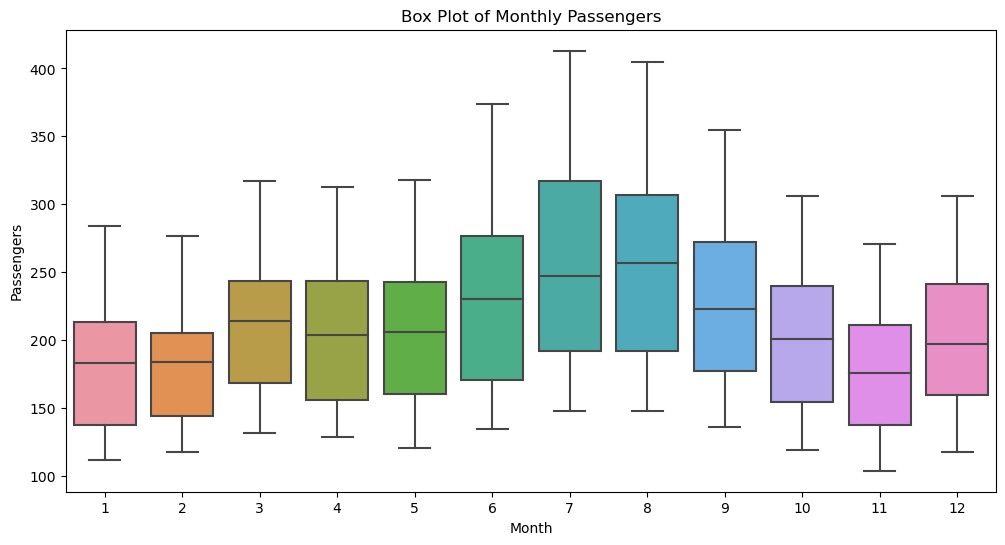

In [11]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['Month'].dt.month, y=data['Passengers'])
plt.title('Box Plot of Monthly Passengers')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.show()


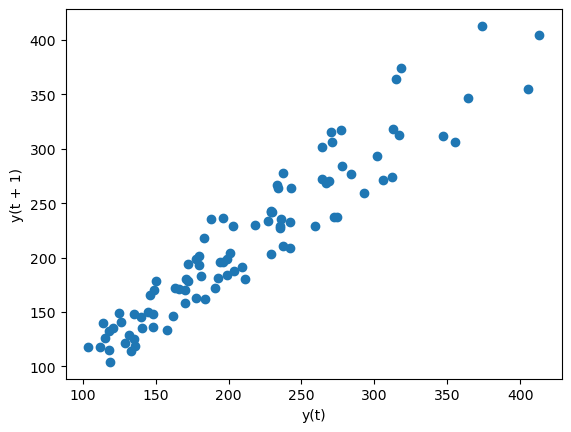

In [12]:
lag_plot(data['Passengers'])
plt.show()

<Axes: xlabel='Month', ylabel='Passengers'>

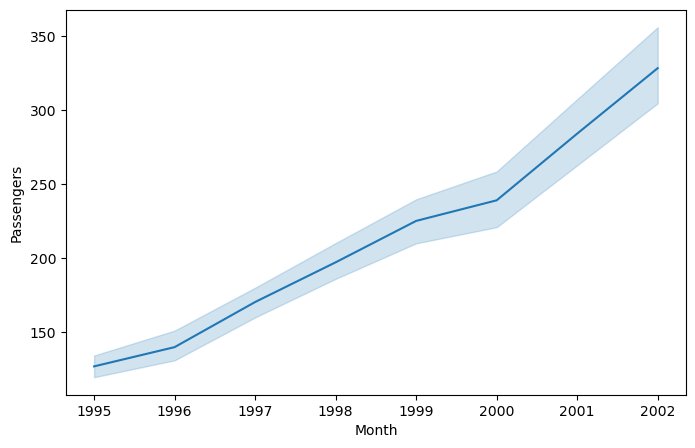

In [13]:
plt.figure(figsize=(8,5))
sns.lineplot(x=data['Month'].dt.year,y="Passengers",data=data)

<Axes: xlabel='Month', ylabel='Month'>

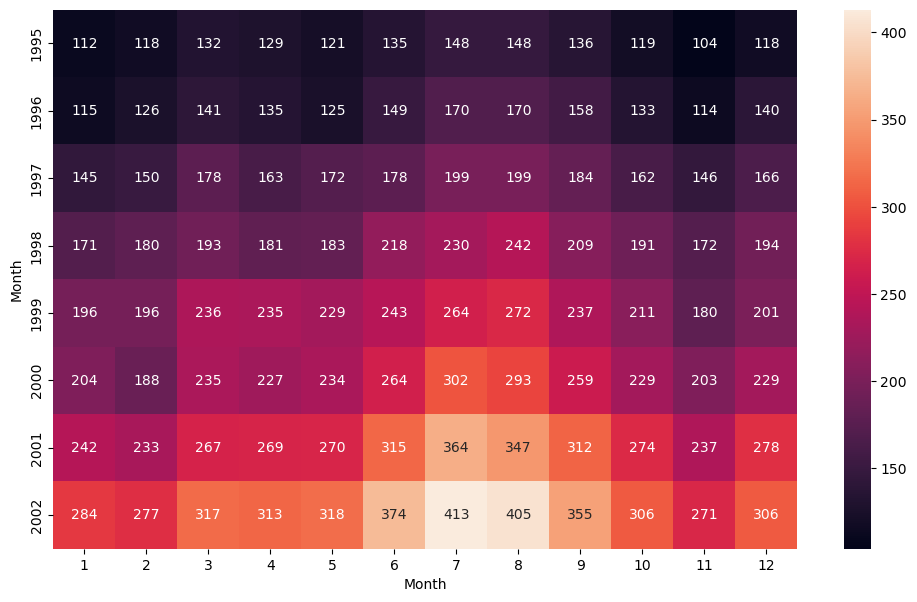

In [14]:
plt.figure(figsize=(12, 7))
heatmap_y_month = pd.pivot_table(data=data,values="Passengers",index=data['Month'].dt.year,columns=data['Month'].dt.month,aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


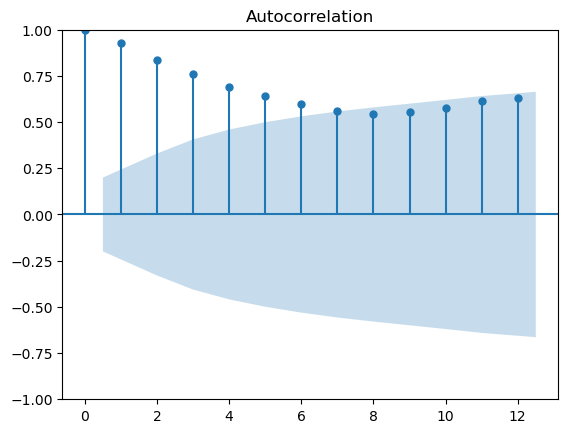

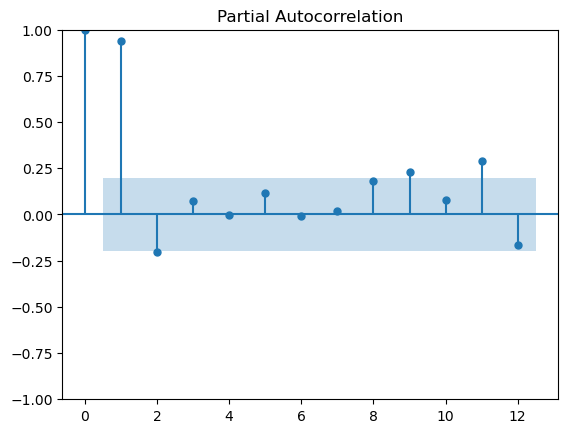

In [15]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Passengers,lags=12)
tsa_plots.plot_pacf(data.Passengers,lags=12)
plt.show()

# Data Driven Forecasting Methods

In [16]:
#Splitting data
train, test = train_test_split(data, test_size=0.3, shuffle=False)

## 1. Moving Average Method

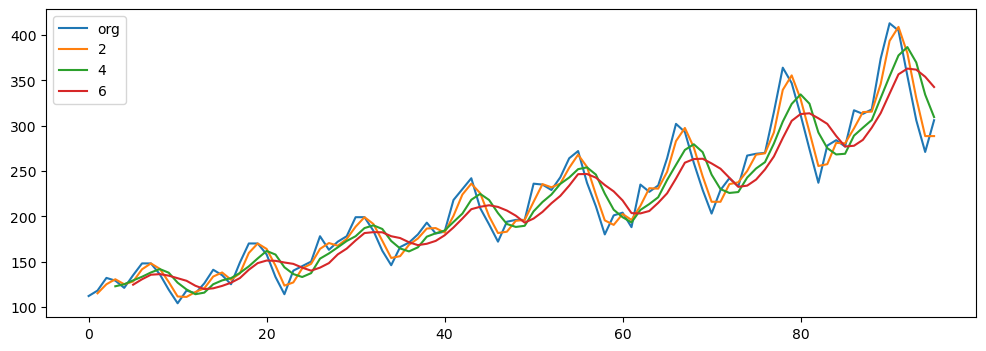

In [17]:
plt.figure(figsize=(12,4))
data.Passengers.plot(label="org")
for i in range(2,8,2):
    data["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

###  Time series decomposition plot

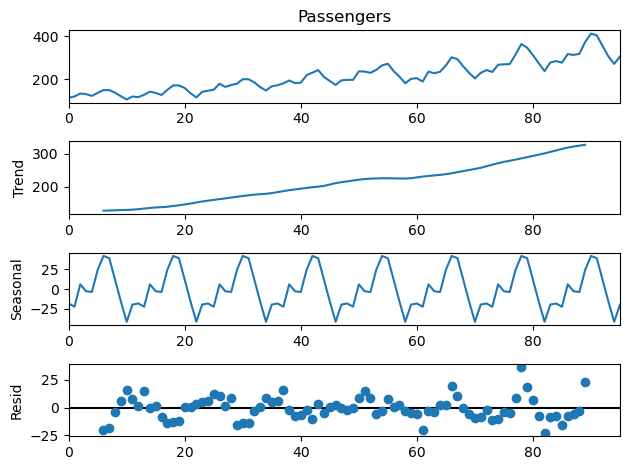

In [18]:
decompose_ts_add = seasonal_decompose(data.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

### Evaluation Metric RMSE

In [19]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

## 2. Simple Exponential Method

In [20]:
warnings.filterwarnings("ignore")

In [21]:
ses_model = SimpleExpSmoothing(train["Passengers"]).fit()
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
rmse_ses_model = RMSE(test.Passengers, pred_ses)
rmse_ses_model

52.2850277823286

## 3. Holt method

In [22]:
hw_model = Holt(train["Passengers"]).fit()
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
rmse_hw_model = RMSE(test.Passengers, pred_hw)
rmse_hw_model

65.24204797641497

## Holts winter exponential smoothing with additive seasonality and additive trend

In [23]:
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=4).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
rmse_hwe_add_add_model = RMSE(test.Passengers, pred_hwe_add_add)
rmse_hwe_add_add_model

61.611674401642865

## Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [24]:
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
rmse_hwe_model_mul_add_model = RMSE(test.Passengers, pred_hwe_mul_add)
rmse_hwe_model_mul_add_model

59.034261432589744

# Model based Forecasting Methods

In [25]:
# Data preprocessing for models
data["t"] = np.arange(1,97)
data["t_squared"] = data["t"]*data["t"]

data["log_Passengers"] = np.log(data["Passengers"])

data.head()

,Month,Passengers,t,t_squared,log_Passengers
0,1995-01-01,112,1,1,4.718499
1,1995-02-01,118,2,4,4.770685
2,1995-03-01,132,3,9,4.882802
3,1995-04-01,129,4,16,4.859812
4,1995-05-01,121,5,25,4.795791


In [26]:
# Splitting data into Train and Test (77/33)
Train = data.head(67)
Test = data.tail(29)

## 1. Linear Model

In [27]:
linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear_model = RMSE(Test['Passengers'], pred_linear)
rmse_linear_model

47.562517042292235

## 2. Exponential Model

In [28]:
Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp_model = RMSE(Test['Passengers'], np.exp(pred_Exp))
rmse_Exp_model

42.21818467858797

## 3. Quadratic Model

In [29]:
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad_model = RMSE(Test['Passengers'], pred_Quad)
rmse_Quad_model

43.090083301719694

## 4. Additive Seasonality model

In [30]:
add_sea_model = ExponentialSmoothing(Train['Passengers'], seasonal='add', seasonal_periods=12).fit()
pred_add_sea = add_sea_model.predict(start=test.index[0], end=test.index[-1])
rmse_add_sea = RMSE(Test['Passengers'], pred_add_sea)
rmse_add_sea

48.26807203843644

## 5. Additive Seasonality Quadratic model

In [31]:
add_sea_quad_model = ExponentialSmoothing(Train['Passengers'],seasonal='add',seasonal_periods=4,trend='add',damped=True,use_boxcox=True).fit()
pred_add_sea_quad = add_sea_quad_model.predict(start=Test.index[0], end=Test.index[-1])
rmse_add_sea_Quad_model = RMSE(Test['Passengers'], pred_add_sea_quad)
rmse_add_sea_Quad_model

72.68282776171132

## 6. Multiplicative Seasonality model

In [32]:
Mul_sea = ExponentialSmoothing(Train['Passengers'], seasonal='mul', seasonal_periods=4,trend='add',damped=True).fit()
pred_Mult_sea = Mul_sea.predict(start=Test.index[0], end=Test.index[-1])
rmse_Mul_sea = RMSE(Test['Passengers'], pred_Mult_sea)
rmse_Mul_sea

53.83145377961753

## 7. Multiplicative Additive Seasonality model

In [33]:
Mul_Add_sea = ExponentialSmoothing(Train['Passengers'],seasonal='mul',seasonal_periods=4,trend='add',damped=True).fit()
pred_Mult_add_sea = Mul_Add_sea.predict(start=Test.index[0], end=Test.index[-1])
rmse_Mul_Add_sea = RMSE(Test['Passengers'], pred_Mult_add_sea)
rmse_Mul_Add_sea

53.83145377961753

In [34]:
list = [['Simple Exponential Method',rmse_ses_model], ['Holt method',rmse_hw_model],
          ['HW exp smoothing add',rmse_hwe_add_add_model],['HW exp smoothing mult',rmse_hwe_model_mul_add_model],
          ['Linear Mode',rmse_linear_model],['Exp model',rmse_Exp_model],['Quad model',rmse_Quad_model],
          ['add seasonality',rmse_add_sea],['Quad add seasonality',rmse_add_sea_Quad_model],
          ['Mult Seasonality',rmse_Mul_sea],['Mult add seasonality',rmse_Mul_Add_sea]]

In [35]:
df = pd.DataFrame(list, columns =['Model', 'RMSE_Value']) 
df

,Model,RMSE_Value
0,Simple Exponential Method,52.285028
1,Holt method,65.242048
2,HW exp smoothing add,61.611674
3,HW exp smoothing mult,59.034261
4,Linear Mode,47.562517
5,Exp model,42.218185
6,Quad model,43.090083
7,add seasonality,48.268072
8,Quad add seasonality,72.682828
9,Mult Seasonality,53.831454


# ARIMA method

In [36]:
# Extract the 'Sales' column as a time series
ts = data['Passengers']

In [37]:
# Split the data into training and testing sets
train_size = int(len(ts) * 0.7)
Train, Test = ts[:train_size], ts[train_size:]

In [38]:
# Define the range of values for p, d, q
p_values = range (1,4)
d_values = range (1,4)
q_values = range (1,4)

In [39]:
# Perform grid search
best_rmse = float('inf')
best_params = None

In [40]:
for p, d, q in product(p_values, d_values, q_values):
    order = (p, d, q)
    try:
        # Fit ARIMA model
        model = ARIMA(Train, order=order)
        fit_model = model.fit()

        # Forecast
        forecast = fit_model.forecast(steps=len(Test))

        # Calculate RMSE
        rmse = sqrt(mean_squared_error(Test, forecast))

        # Update best parameters if current RMSE is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = order

        print(f'Order: {order}, RMSE: {rmse}')

    except Exception as e:
        continue

Order: (1, 1, 1), RMSE: 52.77309224153029
Order: (1, 1, 2), RMSE: 61.752920859109516
Order: (1, 1, 3), RMSE: 62.14270688521157
Order: (1, 2, 1), RMSE: 71.83093390400165
Order: (1, 2, 2), RMSE: 68.19721082327104
Order: (1, 2, 3), RMSE: 70.25570834249612
Order: (1, 3, 1), RMSE: 697.3422382609535
Order: (1, 3, 2), RMSE: 724.0299877878406
Order: (1, 3, 3), RMSE: 120.5920580422469
Order: (2, 1, 1), RMSE: 63.044823878998585
Order: (2, 1, 2), RMSE: 64.65636297728456
Order: (2, 1, 3), RMSE: 61.3649853974958
Order: (2, 2, 1), RMSE: 63.05754378631967
Order: (2, 2, 2), RMSE: 70.64315521591668
Order: (2, 2, 3), RMSE: 69.74068859357945
Order: (2, 3, 1), RMSE: 597.3878884809185
Order: (2, 3, 2), RMSE: 734.9342594696643
Order: (2, 3, 3), RMSE: 136.30323814274257
Order: (3, 1, 1), RMSE: 63.36301879304955
Order: (3, 1, 2), RMSE: 62.7234776634077
Order: (3, 1, 3), RMSE: 64.47032326605765
Order: (3, 2, 1), RMSE: 59.10551863756656
Order: (3, 2, 2), RMSE: 65.81439235829511
Order: (3, 2, 3), RMSE: 42.446011

In [41]:
print(f'Best parameters: {best_params}, Best RMSE: {best_rmse}')

Best parameters: (3, 2, 3), Best RMSE: 42.44601186599698


## Building final model with least RMSE value

In [42]:
data.head()

,Month,Passengers,t,t_squared,log_Passengers
0,1995-01-01,112,1,1,4.718499
1,1995-02-01,118,2,4,4.770685
2,1995-03-01,132,3,9,4.882802
3,1995-04-01,129,4,16,4.859812
4,1995-05-01,121,5,25,4.795791


In [43]:
final_model = smf.ols('log_Passengers~t',data=data).fit()
pred_final = pd.Series(Exp.predict(pd.DataFrame(data['t'])))
rmse_Exp_model = RMSE(data['Passengers'], np.exp(pred_final))
rmse_Exp_model

29.82118043328755

In [44]:
pred_df = pd.DataFrame({'Actual' : data.log_Passengers, 'Predicted' : pred_final})
pred_df

,Actual,Predicted
0,4.718499,4.769563
1,4.770685,4.781156
2,4.882802,4.792749
3,4.859812,4.804342
4,4.795791,4.815935
...,...,...
91,6.003887,5.824526
92,5.872118,5.836119
93,5.723585,5.847712
94,5.602119,5.859305


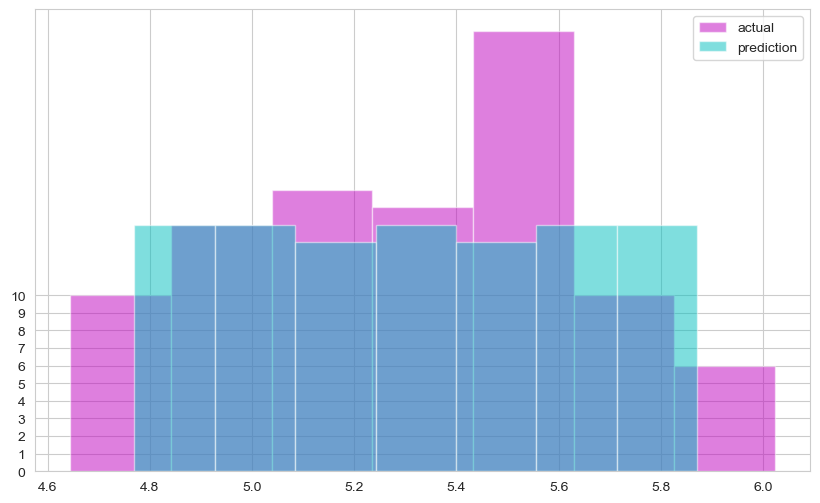

In [45]:
# Actual Vs Predicted graph
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6) 
_, ax = plt.subplots()
ax.hist(data.log_Passengers, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(pred_final, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,11))
ax.legend(loc = 'best')
plt.show()

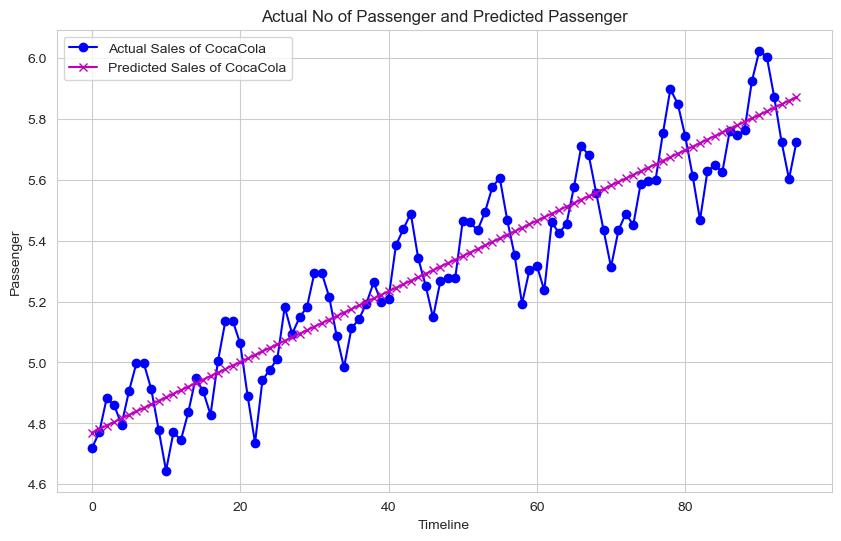

In [46]:
plt.plot(data.log_Passengers, color='b',marker='o', label='Actual Sales of CocaCola')
plt.plot(pred_final, color='m',marker='x', label='Predicted Sales of CocaCola')
plt.title('Actual No of Passenger and Predicted Passenger')
plt.xlabel("Timeline")
plt.ylabel("Passenger")
plt.legend()
plt.rcParams['figure.figsize'] = (10,8) 
plt.show()